In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [18]:
class DoubleConv(nn.Module):
    """
    Double Convolution block used in UNet.
    Performs: Conv2d -> BatchNorm -> ReLU -> Conv2d -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            # First convolution layer
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            # Second convolution layer
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [19]:
class UNet(nn.Module):
    """
    UNet architecture adapted for input shape (N, 10, 64, 64) to output shape (N, 16, 16)
    B represents batch size
    """
    def __init__(self):
        super().__init__()
        
        # Encoder path (downsampling)
        self.enc1 = DoubleConv(10, 64)  # Input: (N, 10, 64, 64) -> Output: (N, 64, 64, 64)
        self.enc2 = DoubleConv(64, 128)  # After pooling: (N, 64, 32, 32) -> (N, 128, 32, 32)
        self.enc3 = DoubleConv(128, 256)  # After pooling: (N, 128, 16, 16) -> (N, 256, 16, 16)
        
        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)   # 2x2 pooling window, # Step size = 2, reduces spatial dimensions by half
        
        # Decoder path (upsampling)
        self.up2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)   # Doubles spatial dimensions
        
        # Takes concatenated input (256 channels) from skip connection
        self.dec2 = DoubleConv(256, 128)  # Input: (N, 256, 32, 32) -> Output: (N, 128, 32, 32)
        
        self.up1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        
        self.dec1 = DoubleConv(128, 64)   # Input: (N, 128, 64, 64) -> Output: (N, 64, 64, 64)
        
        # Final convolution to get desired number of output channels
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1)     # Final number of channels needed, # 1x1 convolution to adjust channel dimension
        
        # Adaptive pooling to get final spatial dimensions of 16x16
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(16, 1))  # Reduces spatial dimensions to 16x1

    def forward(self, x):
        # Encoder pathway with skip connections
        enc1 = self.enc1(x)           # Save for skip connection
        x = self.pool(enc1)           # Downsample
        
        enc2 = self.enc2(x)           # Save for skip connection
        x = self.pool(enc2)           # Downsample
        
        x = self.enc3(x)              # Bottom of U-Net
        
        # Decoder pathway
        x = self.up2(x)               # Upsample
        x = torch.cat([x, enc2], dim=1)  # Skip connection concatenation along channel dimension
        x = self.dec2(x)
        
        x = self.up1(x)               # Upsample
        x = torch.cat([x, enc1], dim=1)  # Skip connection concatenation
        x = self.dec1(x)
        
        x = self.final_conv(x)        # Adjust number of channels
        x = self.adaptive_pool(x)     # Get final spatial dimensions
        x = x.squeeze(-1)             # Remove last dimension of size 1
        
        return x
        

class Dataset(Dataset):
    """
    dataset class for handling U and D data pairs
    U_data shape: (N, 10, 64, 64) where N is number of samples
    D_data shape: (N, 16, 16)
    """
    def __init__(self, U_data, D_data):
        self.U_data = U_data
        self.D_data = D_data

    def __len__(self):
        return len(self.U_data)

    def __getitem__(self, idx):
        return self.U_data[idx], self.D_data[idx]


In [25]:
def plot_results(predictions, targets, num_examples=10):
    """
    - predictions: model predictions array
    - targets: ground truth array
    - num_examples: number of example pairs to show
    """ 
    # Example Predictions
    num_examples = min(num_examples, len(predictions))
    for i in range(num_examples):
        fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        fig2.suptitle(f'Example {i+1}', fontsize=16, y=1.05)
        
        # Prediction
        im1 = ax1.imshow(predictions[i], cmap='viridis')
        ax1.set_title('Prediction')
        divider = make_axes_locatable(ax1)
        cax1 = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im1, cax=cax1)
        
        # Target
        im2 = ax2.imshow(targets[i], cmap='viridis')
        ax2.set_title('Target')
        divider = make_axes_locatable(ax2)
        cax2 = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im2, cax=cax2)
        
        # Difference
        difference = predictions[i] - targets[i]
        max_diff = max(abs(difference.min()), abs(difference.max()))
        im3 = ax3.imshow(difference, cmap='RdBu_r', 
                        vmin=-max_diff, vmax=max_diff)
        ax3.set_title('Difference (Prediction - Target)')
        divider = make_axes_locatable(ax3)
        cax3 = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im3, cax=cax3)
        plt.tight_layout()
    
    plt.show()

In [26]:
def test_model(model, test_loader, device):
    """
    Test the model and return predictions and actual values
    """
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            # Move predictions and targets to CPU for numpy conversion
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_test_loss = test_loss / len(test_loader)
    return np.array(all_predictions), np.array(all_targets), avg_test_loss

def calculate_metrics(predictions, targets):
    """
    Calculate various performance metrics
    """
    mse = mean_squared_error(targets.reshape(-1), predictions.reshape(-1))
    rmse = np.sqrt(mse)
    r2 = r2_score(targets.reshape(-1), predictions.reshape(-1))
    
    # Calculate relative error
    relative_error = np.abs(predictions - targets) / (np.abs(targets) + 1e-10)
    mean_relative_error = np.mean(relative_error)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Mean Relative Error': mean_relative_error
    }

In [27]:
def evaluate_model(model, test_data, batch_size=32, device='cuda'):
    """
    Complete evaluation pipeline
    """
    # Create test dataloader
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # Get predictions
    predictions, targets, test_loss = test_model(model, test_loader, device)
    
    # Calculate metrics
    metrics = calculate_metrics(predictions, targets)
    
    # Print metrics
    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot results
    plot_results(predictions, targets)
    
    return predictions, targets, metrics

In [28]:
def load_simulation_data(filepath):
    # Load the npz file
    data = np.load(filepath)
    
    # Convert to PyTorch tensors
    D = data['D']
    u = data['u']
    t = data['t']
    
    return D, u, t


filepath = "DataSet_test/simulation_data.npz"
D, u, t = load_simulation_data(filepath)

num_steps = 10
u_n = []
U = []
D_n = []
for i in range(np.shape(t)[0]):
    if (i+1)/num_steps > (i+1)//num_steps:
        u_n.append(u[i])
    else:
        u_n.append(u[i])
        U.append(u_n)
        D_n.append(D[i])
        u_n = []
        

# Hyperparameters
batch_size = 200    # Number of samples processed in each training iteration
num_epochs = 1000    # Number of complete passes through the training dataset

test_U_tensor = torch.tensor(U, dtype=torch.float32) 
test_D_tensor = torch.tensor(D_n, dtype=torch.float32) 

/tmp/ipykernel_88801/3108710462.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_model.pt'))



Test Results:
Test Loss: 0.0100
MSE: 0.0100
RMSE: 0.1000
R2: 0.9762
Mean Relative Error: 0.6938


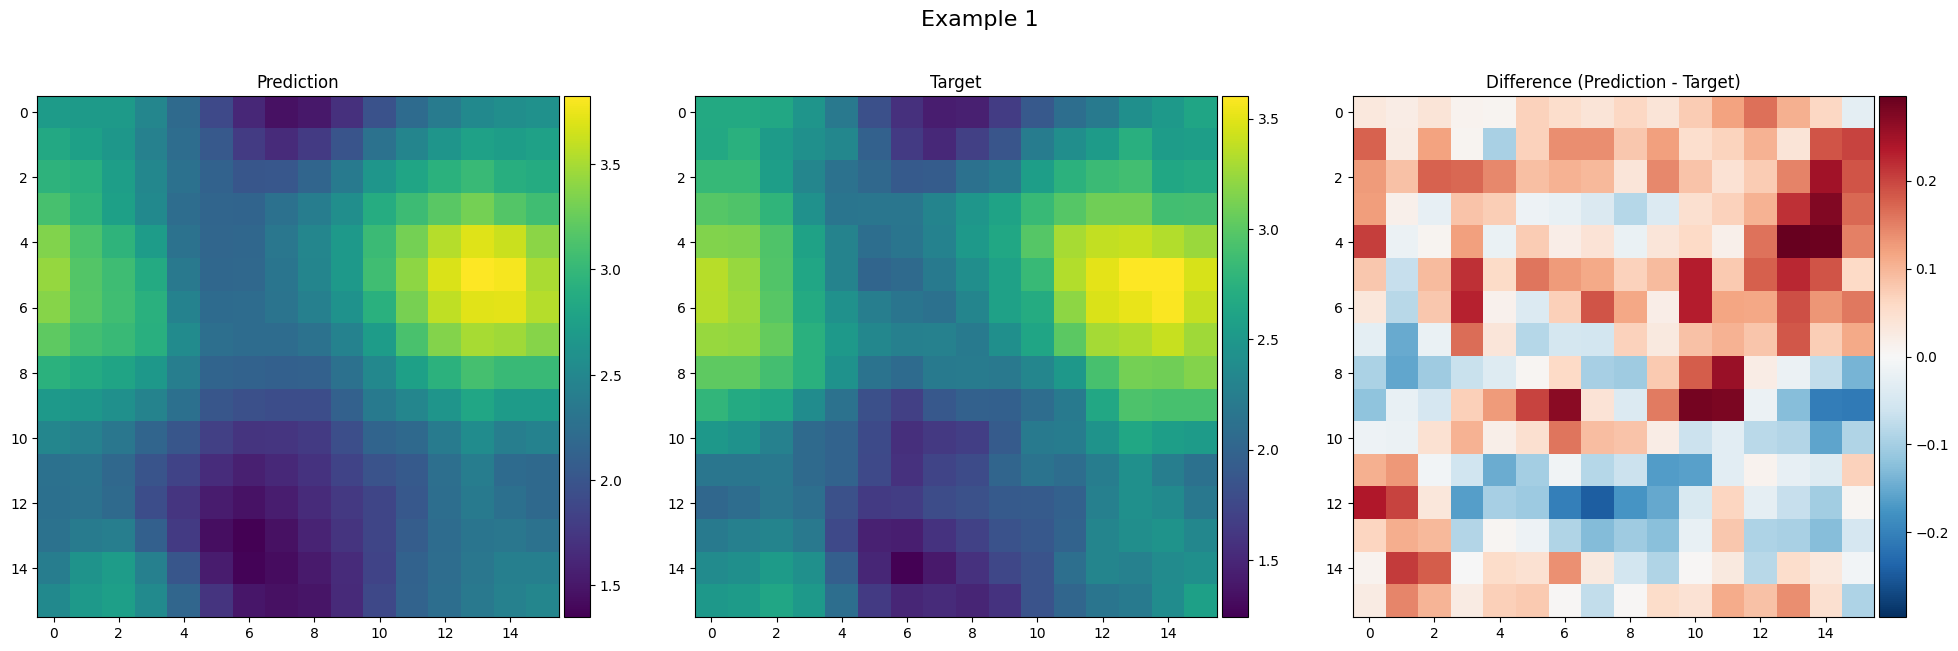

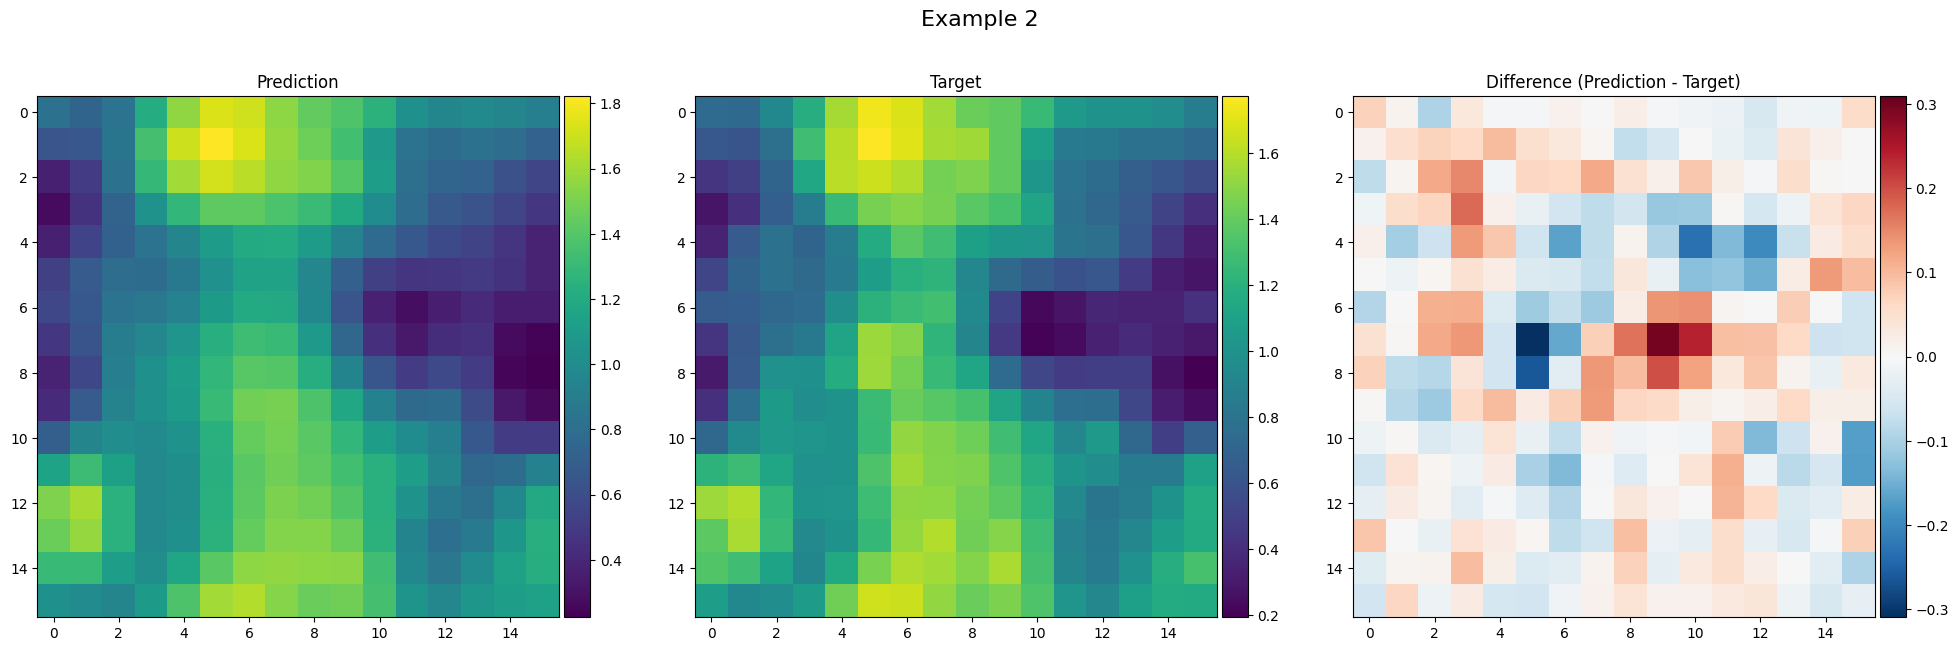

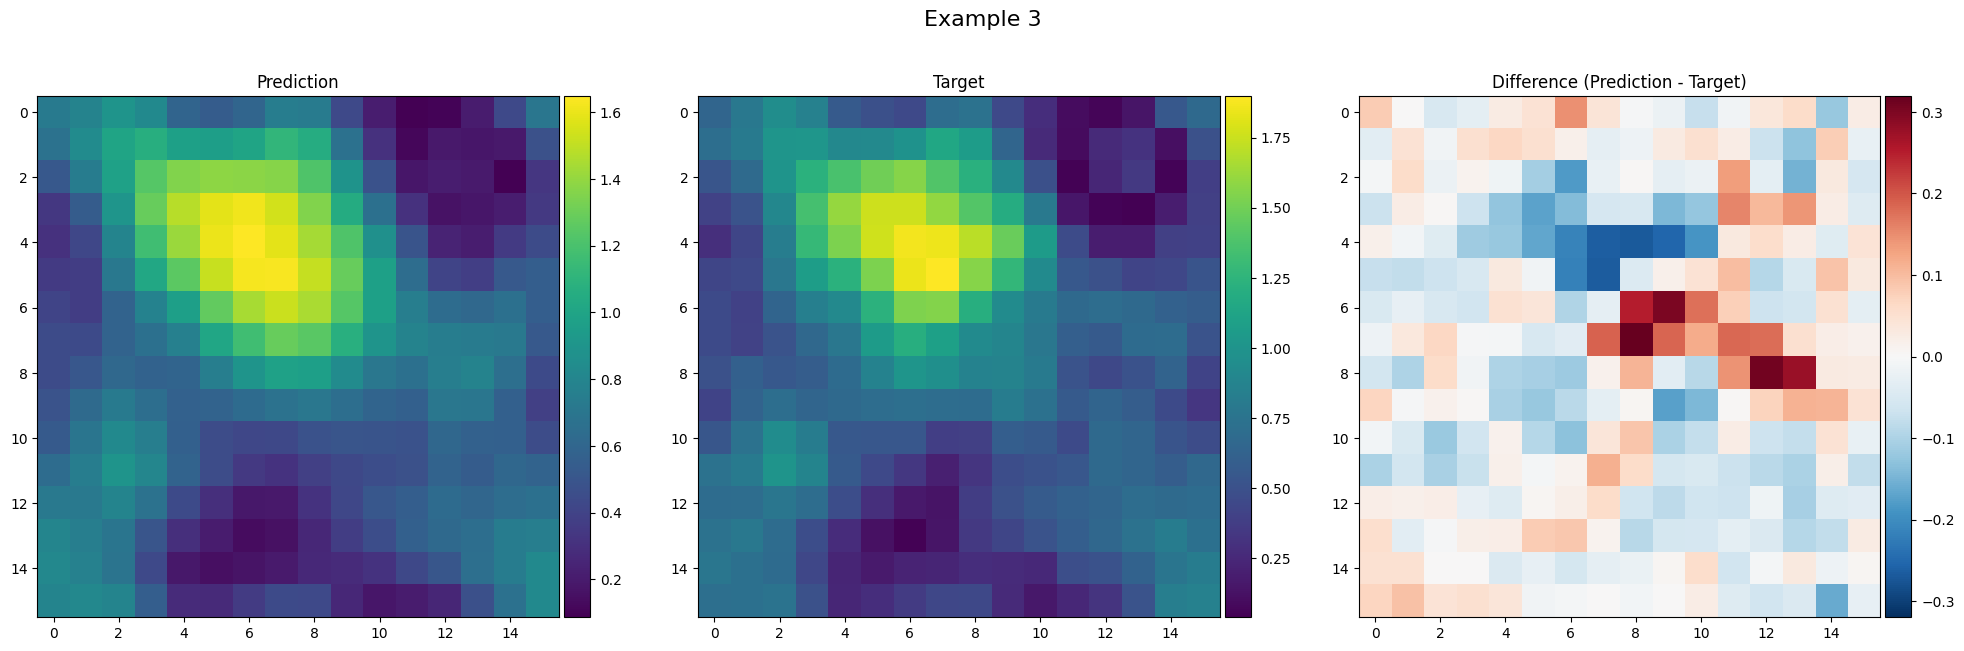

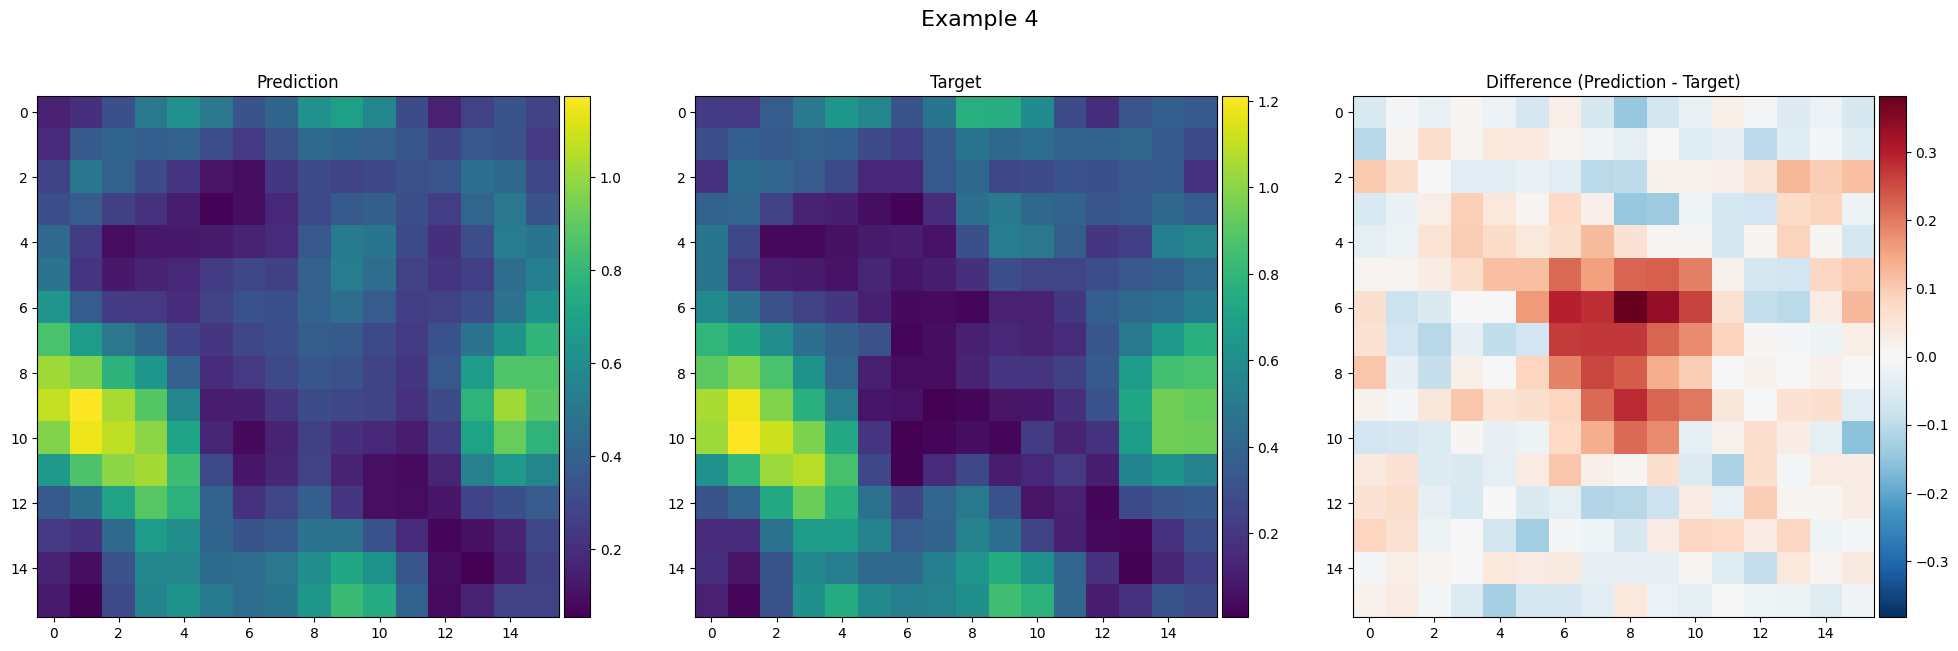

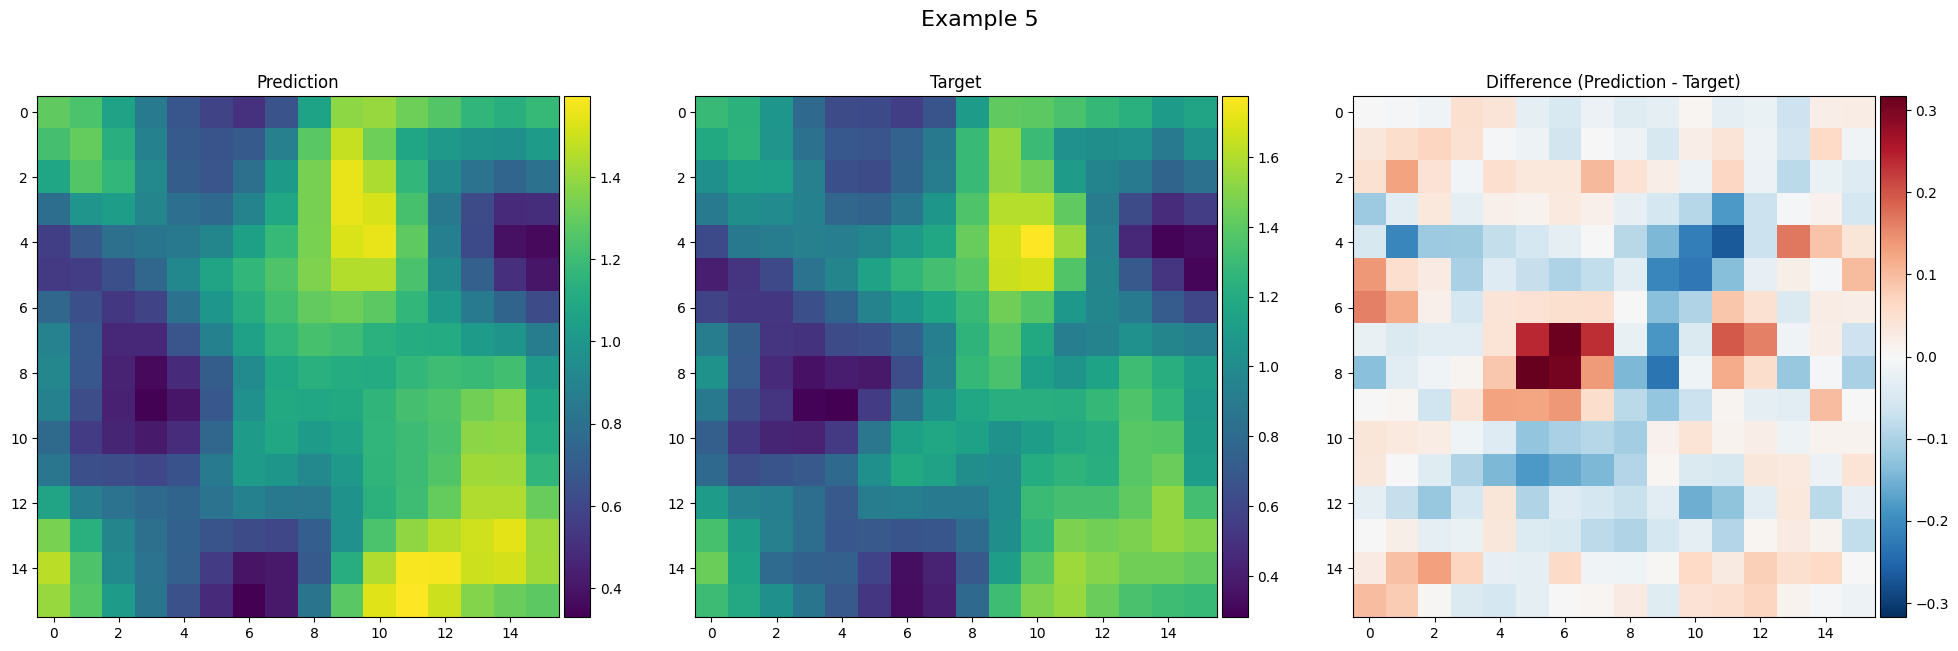

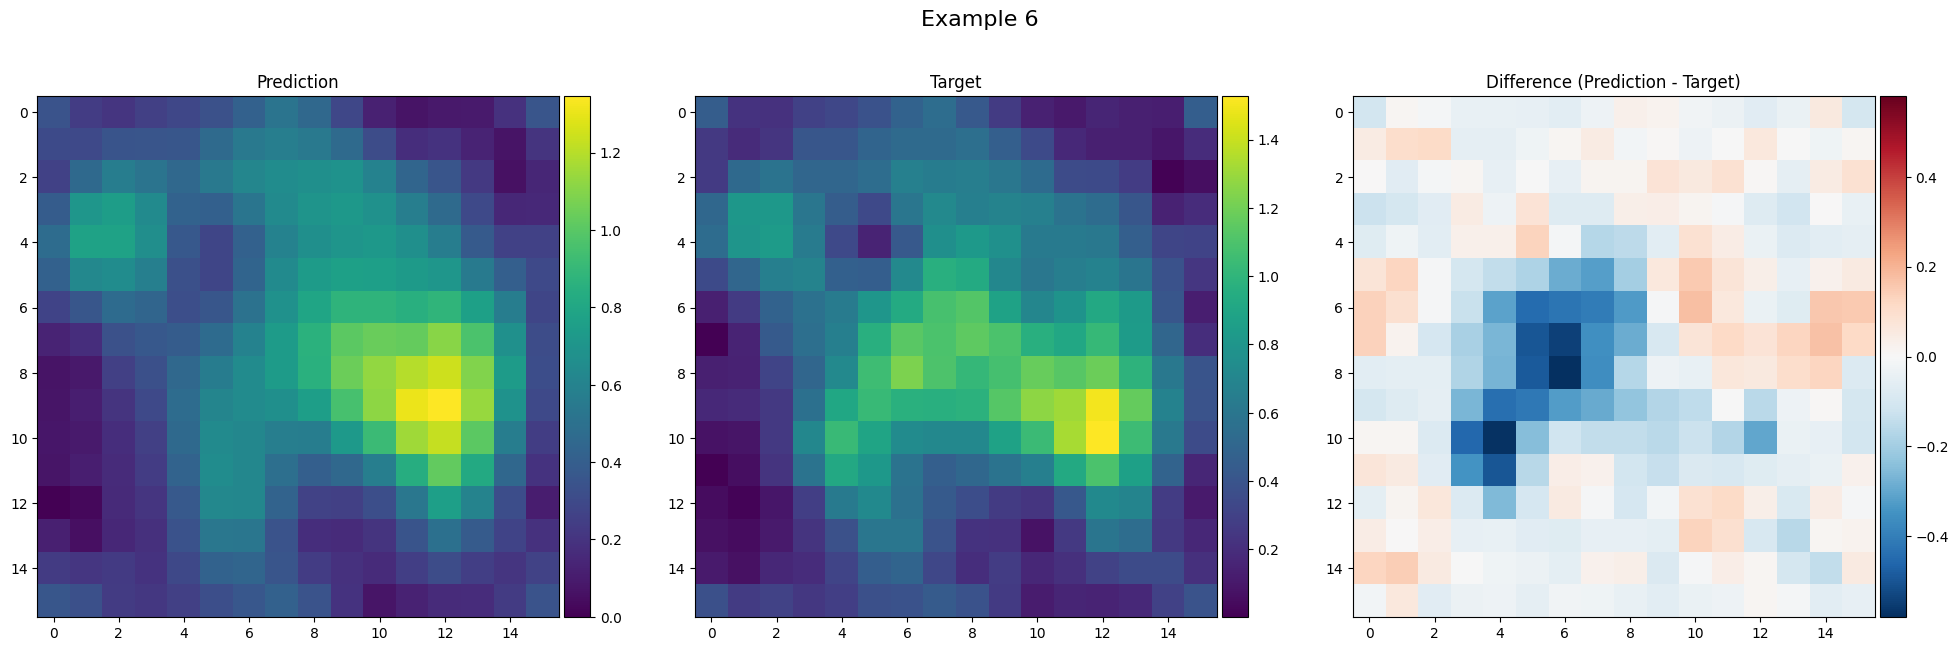

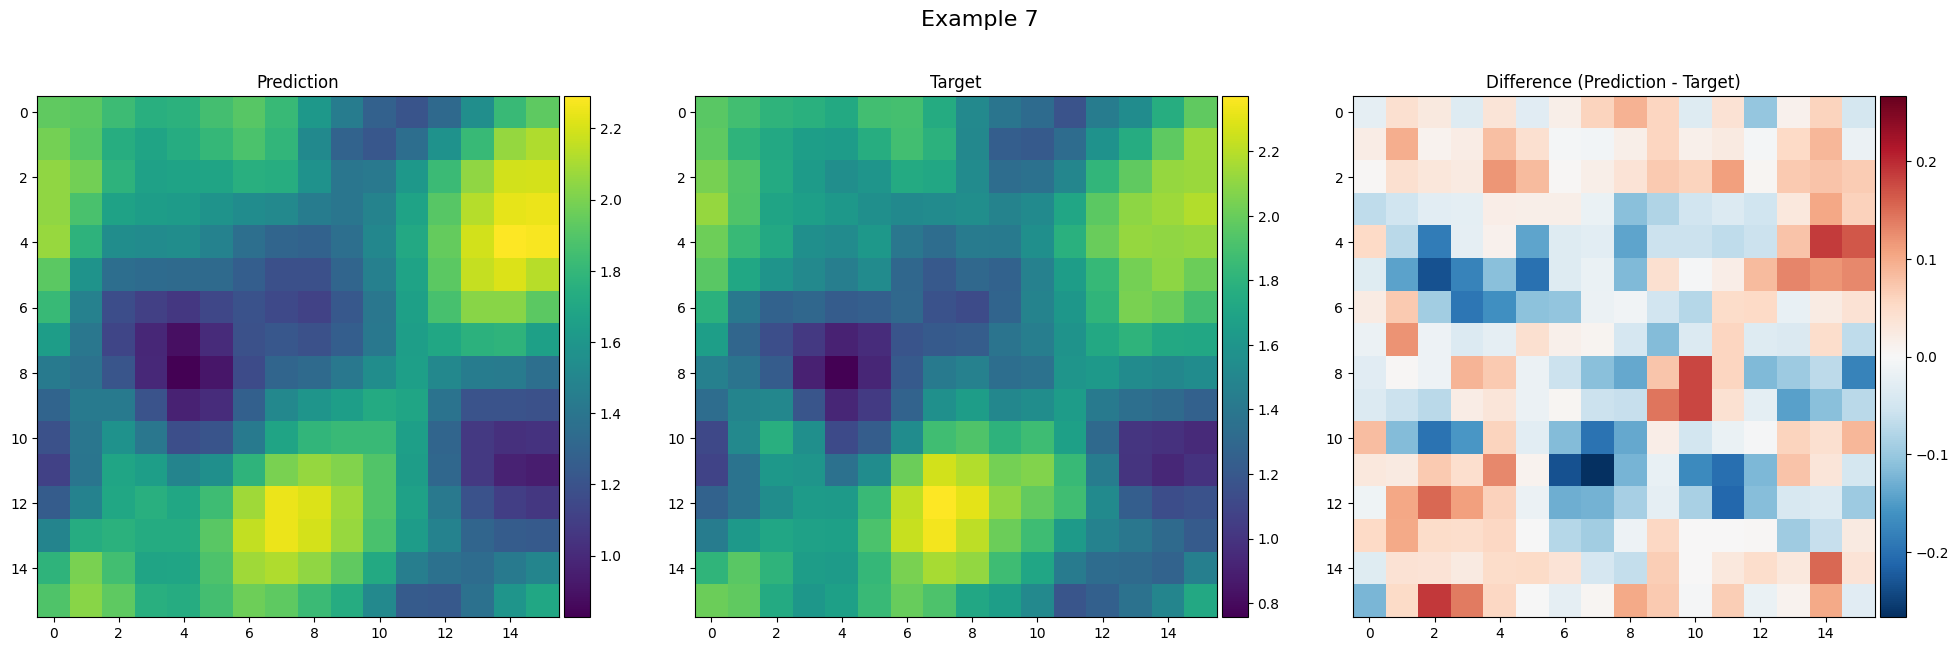

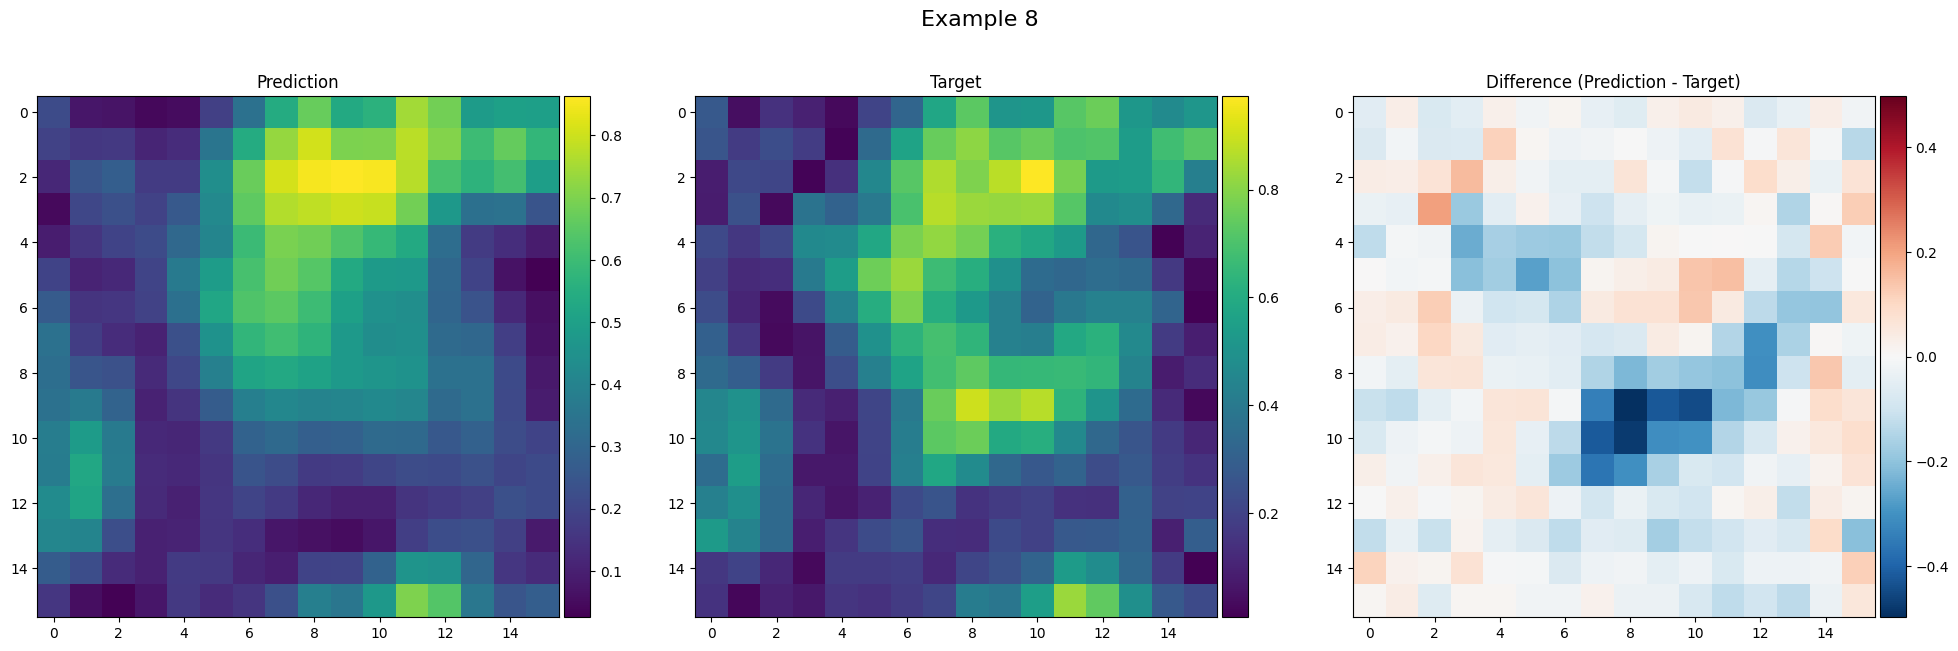

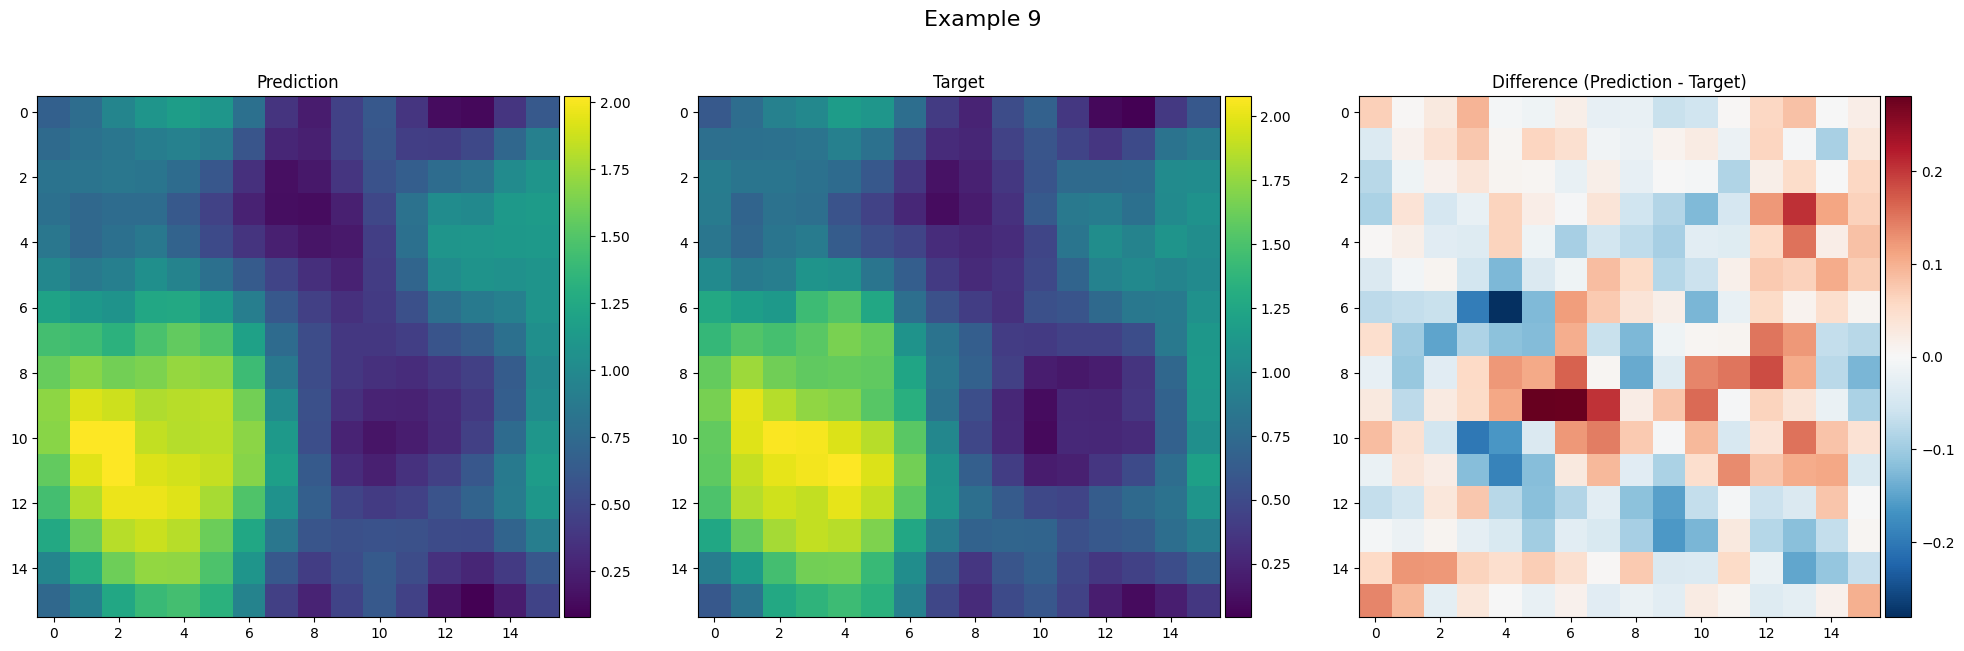

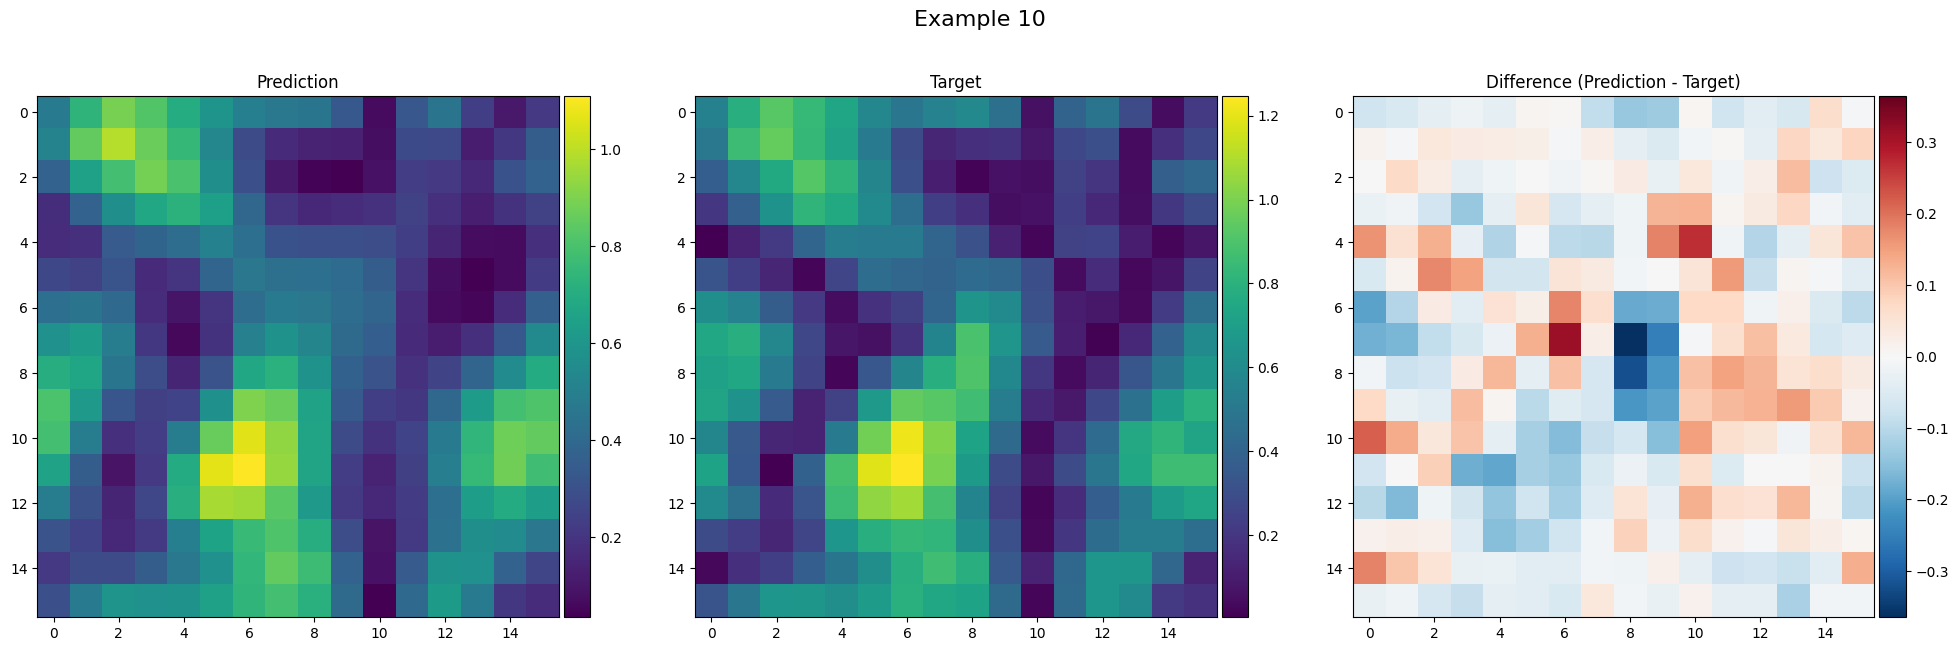

In [29]:
# Load your trained model
model = UNet()
model.load_state_dict(torch.load('final_model.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Create test dataset
test_dataset = Dataset(test_U_tensor, test_D_tensor)

predictions, targets, metrics = evaluate_model(model, test_dataset, device=device)